In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#constantes
Kb = 8.6173324e-5

SIZE = 3
TEMPERATURAS = [i for i in np.arange(250,350.1,0.1)]

E_A = -1
E_B = -1
E_AA = -0.05
E_BB = -0.05
E_AB = -0.05

N_A = 1
N_B = (SIZE * SIZE) - N_A
E_on_site = N_A * E_A + N_B * E_B

In [3]:
def possible_matrices(size, N_a):
    matrices = []
    # Define the counts of A and B
    N_b = (size * size) - N_a

    # Generate all possible arrangements of "A" and "B" in the matrix
    elements = ['A'] * N_a + ['B'] * N_b
    arrangements = set(itertools.permutations(elements, size * size))

    # Iterate over each arrangement and reshape it into a matrix
    for arrangement in arrangements:
        matrix = np.array(arrangement).reshape(size, size)
        matrices.append(matrix)
    
    #print(len(matrices))
    return matrices

In [4]:
def determinar_vizinhos(matrix, size):

    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    i, j = np.indices((size, size))

    # Reshape offsets to have an extra dimension for broadcasting
    reshaped_offsets = offsets.reshape(1, 1, -1, 2)

    # Calculate indices of neighboring elements
    neighbor_indices = (i[..., np.newaxis, np.newaxis] + reshaped_offsets) % np.array([size,size])
    #print(neighbor_indices)

    # Create a dictionary to store neighbors
    vizinhos = {(x, y): matrix[neighbor_indices[x, y, :, 0], neighbor_indices[x, y, :, 1]].tolist() for x in range(size) for y in range(size)}

    return vizinhos


In [5]:
def energia_total(matrix, vizinhos_dict, E_AB, E_AA, E_BB, E_on_site):
    coordenadas_on_site = np.array(list(vizinhos_dict.keys()))
    on_site_values = matrix[coordenadas_on_site[:, 0], coordenadas_on_site[:, 1]]
    vizinhos_values = np.array([vizinhos_dict[(x, y)] for x, y in coordenadas_on_site])

    energia_vizinhos = np.where(vizinhos_values != on_site_values[:, None], E_AB, 0)

    energia_vizinhos += np.where(
        np.logical_and(vizinhos_values == on_site_values[:, None], on_site_values[:, None] == 'A'), E_AA, 0)

    energia_vizinhos += np.where(
        np.logical_and(vizinhos_values == on_site_values[:, None], on_site_values[:, None] == 'B'), E_BB, 0)

    energia_matrix = np.sum(energia_vizinhos) + E_on_site

    return energia_matrix


In [6]:
def helmholtz(energias, temperatura):
    """Essa função calcula o valor da função de partição
    
    Args:
        
        energias: lista com a energia de cada configuração da célula.
        temperatura: temperatura na qual estaria a célula.
        
    Return:
    
        Z: valor da função de partição em uma temperatura.
    """
    beta = 1.0 / (Kb * temperatura)
    Z = 0.0
    for energia in energias:
        Z += np.exp(-beta * energia)

    F = beta * np.log(Z)
    
    return F

In [7]:
def analise(size, N_a, temperaturas):
    energia_matrix_list = []
    energia_helmholtz_list = []
    
    matrices = possible_matrices(size,N_a)

    for matrix in matrices:
        vizinhos = determinar_vizinhos(matrix,size)
        energia_matrix = energia_total(matrix, vizinhos, E_AB, E_AA, E_BB, E_on_site)
        energia_matrix_list.append(energia_matrix)

    for T in temperaturas:
        energia_helmholtz = helmholtz(energia_matrix_list,T)
        energia_helmholtz_list.append(energia_helmholtz)

    data = pd.DataFrame({"Temperatura": temperaturas, "Energia de Helmholtz": energia_helmholtz_list})
    return data

In [8]:
df_helmholtz = analise(SIZE,N_A,TEMPERATURAS)
df_helmholtz

,Temperatura,Energia de Helmholtz
0,250.0,23372.080092
1,250.1,23353.434404
2,250.2,23334.811053
3,250.3,23316.210002
4,250.4,23297.631216
...,...,...
997,349.7,11965.786679
998,349.8,11958.966994
999,349.9,11952.153148
1000,350.0,11945.345137


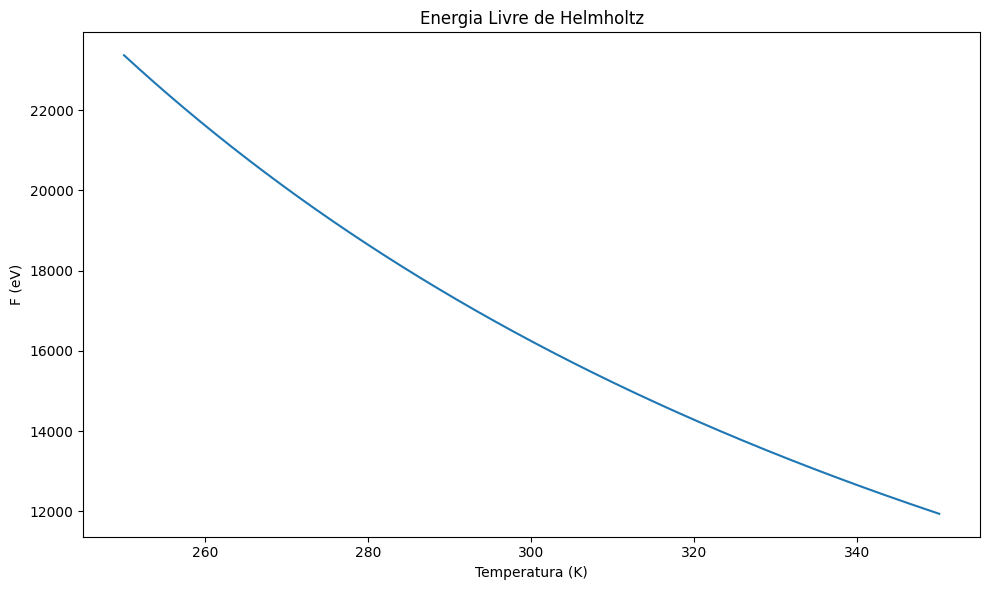

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_helmholtz, x=df_helmholtz['Temperatura'], y=df_helmholtz['Energia de Helmholtz'])
sns.color_palette("Paired")
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('F (eV)')
plt.tight_layout()
# fig.get_figure() #'pega' o gráfico para salvar
# fig.savefig("helmholtz.pdf") #salva o gráfico 

### Playground

In [10]:
def calcular_vizinhos_v1(matriz):
    linhas, colunas = matriz.shape
    vizinhos = {}

    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    indices = itertools.product(range(linhas), range(colunas))

    for i, j in indices:
        vizinhos[(i, j)] = []

        # Calculate indices of neighboring elements
        neighbor_indices = (np.array([i, j]) + offsets) % np.array([linhas, colunas])

        # Add neighbors to the current element
        for ni, nj in neighbor_indices:
            vizinhos[(i, j)].append(matriz[ni, nj])

    return vizinhos

# Example usage
matriz = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])
vizinhos = calcular_vizinhos_v1(matriz)
print(vizinhos)


{(0, 0): [2, 4, 3, 7], (0, 1): [3, 5, 1, 8], (0, 2): [1, 6, 2, 9], (1, 0): [5, 7, 6, 1], (1, 1): [6, 8, 4, 2], (1, 2): [4, 9, 5, 3], (2, 0): [8, 1, 9, 4], (2, 1): [9, 2, 7, 5], (2, 2): [7, 3, 8, 6]}


In [11]:
import numpy as np

def determinar_vizinhos_v2(matrix, size):
    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    i, j = np.indices((size, size))

    # Reshape offsets to have an extra dimension for broadcasting
    reshaped_offsets = offsets.reshape(1, 1, -1, 2)

    # Calculate indices of neighboring elements
    neighbor_indices = (i[..., np.newaxis, np.newaxis] + reshaped_offsets) % np.array([size, size])

    # Create a dictionary to store neighbors
    vizinhos = {(x, y): [matrix[neighbor_indices[x, y, k, 0]][neighbor_indices[x, y, k, 1]] for k in range(neighbor_indices.shape[2])] for x in range(size) for y in range(size)}

    return vizinhos

matriz_teste = [['AA', 'AB', 'BB'], ['AB', 'BB', 'BB'], ['BB', 'BB', 'BB']]
determiar_vizinho = determinar_vizinhos_v2(matriz_teste, 3)
print(determiar_vizinho)


{(0, 0): ['AB', 'AB', 'BB', 'BB'], (0, 1): ['AB', 'AB', 'BB', 'BB'], (0, 2): ['AB', 'AB', 'BB', 'BB'], (1, 0): ['BB', 'BB', 'AB', 'AB'], (1, 1): ['BB', 'BB', 'AB', 'AB'], (1, 2): ['BB', 'BB', 'AB', 'AB'], (2, 0): ['BB', 'BB', 'BB', 'BB'], (2, 1): ['BB', 'BB', 'BB', 'BB'], (2, 2): ['BB', 'BB', 'BB', 'BB']}
